Welcome to the world where fashion meets computer vision! This is a starter kernel that applies Mask R-CNN with COCO pretrained weights to the task of [iMaterialist (Fashion) 2019 at FGVC6](https://www.kaggle.com/c/imaterialist-fashion-2019-FGVC6).

In [1]:
import os
import gc
import sys
import json
import glob
import random
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imutils
import itertools
from tqdm import tqdm

from imgaug import augmenters as iaa
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedStratifiedKFold

In [2]:
DATA_DIR = Path('/home/ubuntu/efs/kaggle/imaterialist/')
ROOT_DIR = Path('/home/ubuntu/efs/kaggle/imaterialist/maskrcnn/logs')

# For demonstration purpose, the classification ignores attributes (only categories),
# and the image size is set to 512, which is the same as the size of submission masks
NUM_CATS = 46
IMAGE_SIZE = 768

In [3]:
print(ROOT_DIR/'Mask_RCNN')
sys.path.append("/home/ubuntu/github/Mask_RCNN/")
#sys.path.append(ROOT_DIR/'Mask_RCNN')
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

model_path = '/home/ubuntu/efs/kaggle/imaterialist/maskrcnn/logs/fashion20190607T1342/mask_rcnn_fashion_0017.h5'

/home/ubuntu/efs/kaggle/imaterialist/maskrcnn/logs/Mask_RCNN


Using TensorFlow backend.


# Dataset

In [4]:
# Since the submission system does not permit overlapped masks, we have to fix them
def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois

In [5]:
def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img, paddings = resize_aspect_ratio(img)
   
    return img, paddings    
    
class FashionDataset(utils.Dataset):

    def __init__(self, df):
        super().__init__(self)
        
        # Add classes
        for i, name in enumerate(label_names):
            self.add_class("fashion", i+1, name)
        
        # Add images 
        for i, row in df.iterrows():
            self.add_image("fashion", 
                           image_id=row.name, 
                           path=str(DATA_DIR/'train'/row.name), 
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'])

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [label_names[int(x)] for x in info['labels']]
    
    def load_image(self, image_id):
        return resize_image(self.image_info[image_id]['path'])[0]

    def load_mask(self, image_id):
        info = self.image_info[image_id]
                
        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]
            
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            #sub_mask = cv2.resize(sub_mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
            sub_mask, paddings = resize_aspect_ratio(sub_mask)
            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
            
        return np.array(mask, dtype=np.uint8), np.array(labels)


In [6]:
with open(DATA_DIR/"label_descriptions.json") as f:
    label_descriptions = json.load(f)

label_names = [x['name'] for x in label_descriptions['categories']]


segment_df = pd.read_csv(DATA_DIR/"train.csv")
segment_df['CategoryId'] = segment_df['ClassId'].str.split('_').str[0]
image_df = segment_df.groupby('ImageId')['EncodedPixels', 'CategoryId'].agg(lambda x: list(x))
size_df = segment_df.groupby('ImageId')['Height', 'Width'].mean()
image_df = image_df.join(size_df, on='ImageId')



In [7]:
dataset = FashionDataset(image_df)
dataset.prepare()

# Set Config

Mask R-CNN has a load of hyperparameters. I only adjust some of them.

In [8]:
class FashionConfig(Config):
    NAME = "fashion"
    NUM_CLASSES = NUM_CATS + 1 # +1 for the background class
    
    GPU_COUNT = 0
    IMAGES_PER_GPU = 1 # a memory error occurs when IMAGES_PER_GPU is too high
    
    BACKBONE = 'resnet101'
    
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    
    IMAGE_RESIZE_MODE = 'none'
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    
config = FashionConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     0
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      0
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  768
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  768
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [768 768   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

# Predict

In [9]:
def resize_aspect_ratio(img):
    img_h, img_w = img.shape[:2]
    aspect_ratio = img_w/img_h
    MIN_DIM = 512
    MAX_DIM = 768

    if aspect_ratio<1:
        height = MAX_DIM
        width = int(height*aspect_ratio)
    else:
        width = MAX_DIM
        height = int(width/aspect_ratio)        
    
    resized = cv2.resize(img, (width, height))
    paddings = MAX_DIM - np.array(resized.shape[:2])
    upper_paddings = paddings//2
    lower_paddings = paddings - upper_paddings
    resized = cv2.copyMakeBorder(resized, upper_paddings[0], lower_paddings[0],
                                          upper_paddings[1], lower_paddings[1],
                                          cv2.BORDER_CONSTANT, None, 0.0)

    assert resized.shape[:2]==(MAX_DIM, MAX_DIM), resized.shape
    return resized, [upper_paddings, lower_paddings]

#image_id = random.choice(dataset.image_ids)
'''
print(image_id, image_path)
image_path = dataset.image_reference(image_id)[0]
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resized = resize_aspect_ratio(img)
plt.figure(figsize=(15, 15))
plt.imshow(img)
plt.show()
plt.figure(figsize=(15, 15))
plt.imshow(resized)
plt.show()
'''

'\nprint(image_id, image_path)\nimage_path = dataset.image_reference(image_id)[0]\nimg = cv2.imread(image_path)\nimg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)\nresized = resize_aspect_ratio(img)\nplt.figure(figsize=(15, 15))\nplt.imshow(img)\nplt.show()\nplt.figure(figsize=(15, 15))\nplt.imshow(resized)\nplt.show()\n'

In [10]:
class InferenceConfig(FashionConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.7
    #DETECTION_NMS_THRESHOLD = 0.1 # default 0.3
    TEST_MODE = "inference"
    
inference_config = InferenceConfig()


In [ ]:

model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)


assert model_path != '', "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Loading weights from  /home/ubuntu/efs/kaggle/imaterialist/maskrcnn/logs/fashion20190607T1342/mask_rcnn_fashion_0017.h5


In [ ]:
# Load image
image_id = 888

image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config,
                           image_id, use_mini_mask=False)
# Run object detection
results = model.detect([image], verbose=0)

In [12]:
confidences = {class_id:[] for class_id in range(46)}

# Compute VOC-style Average Precision
random.seed(888)
image_ids = np.random.choice(dataset.image_ids, 1000)

In [59]:
def filter_by_confidence(class_ids, scores, mean_confidences):
    '''
    class_ids include index 0 that is background
    mean_confidences do not have index as background
    
    return list of indices to be removed
    '''
    array_size = len(scores)
    to_keep = []
    for i in range(array_size):
        if scores[i]>=mean_confidences[class_ids[i]-1]:
            to_keep.append(i)            
    return to_keep

def compute_batch_ap(image_ids, thresholds = None):
    APs = []
    for image_id in tqdm(image_ids):
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        #for k,v in r.items():
        #    print(k, type(v), v.dtype)
        if thresholds == None: # collect data
            for class_id, score in zip(r['class_ids'], r['scores']):
                confidences[class_id-1].append(score)
        else:
            to_keep = filter_by_confidence(r['class_ids'], r['scores'], thresholds)
            mask = []
            class_ids = []
            scores = []
            rois = []            
            if len(to_keep)>0:
                masks = np.zeros((r['masks'].shape[0],r['masks'].shape[1],len(to_keep)), dtype=np.bool)
            else:
                rois = [[]]
            for i, idx in enumerate(to_keep):
                masks[:,:,i] = r['masks'][:,:,idx]
                scores.append(r['scores'][idx])
                rois.append(r['rois'][idx])
                class_ids.append(r['class_ids'][idx])
            rois = np.array(rois, dtype=np.int32)
            class_ids = np.array(class_ids, np.int32)
            scores = np.array(scores, dtype=np.float32)
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              rois, class_ids, scores, masks)
        APs.append(AP)
    return APs

APs = compute_batch_ap(image_ids, thresholds=mean_confidences)
print("mAP @ IoU=50: ", np.mean(APs))
# Pick a set of random images
#image_ids = np.random.choice(dataset.image_ids, 1000)
#APs = compute_batch_ap(image_ids)
#print("mAP @ IoU=50: ", np.mean(APs))



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<03:25,  4.87it/s]

  0%|          | 2/1000 [00:00<03:25,  4.85it/s]

  0%|          | 3/1000 [00:00<03:52,  4.29it/s]

  0%|          | 4/1000 [00:01<04:22,  3.80it/s]

  0%|          | 5/1000 [00:01<04:46,  3.47it/s]

  1%|          | 6/1000 [00:02<08:56,  1.85it/s]

  1%|          | 7/1000 [00:02<07:27,  2.22it/s]

  1%|          | 8/1000 [00:02<06:21,  2.60it/s]

  1%|          | 9/1000 [00:04<10:14,  1.61it/s]

  1%|          | 10/1000 [00:04<09:13,  1.79it/s]

  1%|          | 11/1000 [00:04<07:44,  2.13it/s]

  1%|          | 12/1000 [00:05<06:32,  2.52it/s]

  1%|▏         | 13/1000 [00:05<05:44,  2.86it/s]

  1%|▏         | 14/1000 [00:05<06:22,  2.57it/s]

  2%|▏         | 15/1000 [00:06<05:46,  2.84it/s]

  2%|▏         | 16/1000 [00:07<10:19,  1.59it/s]

  2%|▏         | 17/1000 [00:07<09:20,  1.75it/s]

  2%|▏         | 18/1000 [00:08<09:07,  1.79it/s]

  2%|▏         | 19/1000 [00:08<07:35,  2.15it/

 28%|██▊       | 284/1000 [01:55<04:06,  2.91it/s]

 28%|██▊       | 285/1000 [01:56<04:45,  2.51it/s]

 29%|██▊       | 286/1000 [01:56<04:37,  2.57it/s]

 29%|██▊       | 287/1000 [01:57<05:26,  2.19it/s]

 29%|██▉       | 288/1000 [01:58<08:03,  1.47it/s]

 29%|██▉       | 289/1000 [01:58<06:53,  1.72it/s]

 29%|██▉       | 290/1000 [01:59<05:55,  2.00it/s]

 29%|██▉       | 291/1000 [01:59<05:14,  2.25it/s]

 29%|██▉       | 292/1000 [01:59<05:05,  2.32it/s]

 29%|██▉       | 293/1000 [02:00<04:19,  2.73it/s]

 29%|██▉       | 294/1000 [02:00<05:55,  1.99it/s]

 30%|██▉       | 295/1000 [02:01<06:26,  1.82it/s]

 30%|██▉       | 296/1000 [02:01<05:21,  2.19it/s]

 30%|██▉       | 297/1000 [02:02<04:47,  2.45it/s]

 30%|██▉       | 298/1000 [02:02<04:17,  2.73it/s]

 30%|██▉       | 299/1000 [02:02<04:17,  2.72it/s]

 30%|███       | 300/1000 [02:03<04:01,  2.90it/s]

 30%|███       | 301/1000 [02:03<03:55,  2.97it/s]

 30%|███       | 302/1000 [02:03<04:01,  2.89it/s]

 30%|███    

 57%|█████▋    | 566/1000 [03:47<02:43,  2.65it/s]

 57%|█████▋    | 567/1000 [03:48<02:54,  2.48it/s]

 57%|█████▋    | 568/1000 [03:50<05:54,  1.22it/s]

 57%|█████▋    | 569/1000 [03:50<04:59,  1.44it/s]

 57%|█████▋    | 570/1000 [03:50<03:59,  1.80it/s]

 57%|█████▋    | 571/1000 [03:51<03:37,  1.98it/s]

 57%|█████▋    | 572/1000 [03:51<03:21,  2.12it/s]

 57%|█████▋    | 573/1000 [03:51<02:50,  2.51it/s]

 57%|█████▋    | 574/1000 [03:51<02:26,  2.91it/s]

 57%|█████▊    | 575/1000 [03:52<02:18,  3.06it/s]

 58%|█████▊    | 576/1000 [03:52<02:05,  3.39it/s]

 58%|█████▊    | 577/1000 [03:52<02:06,  3.35it/s]

 58%|█████▊    | 578/1000 [03:52<02:03,  3.42it/s]

 58%|█████▊    | 579/1000 [03:53<01:57,  3.59it/s]

 58%|█████▊    | 580/1000 [03:53<02:04,  3.37it/s]

 58%|█████▊    | 581/1000 [03:54<04:25,  1.58it/s]

 58%|█████▊    | 582/1000 [03:55<03:39,  1.91it/s]

 58%|█████▊    | 583/1000 [03:55<03:08,  2.22it/s]

 58%|█████▊    | 584/1000 [03:55<02:49,  2.45it/s]

 58%|█████▊ 

 85%|████████▍ | 848/1000 [05:52<01:04,  2.37it/s]

 85%|████████▍ | 849/1000 [05:53<01:14,  2.04it/s]

 85%|████████▌ | 850/1000 [05:53<01:02,  2.38it/s]

 85%|████████▌ | 851/1000 [05:53<00:53,  2.78it/s]

 85%|████████▌ | 852/1000 [05:53<00:50,  2.90it/s]

 85%|████████▌ | 853/1000 [05:54<01:03,  2.33it/s]

 85%|████████▌ | 854/1000 [05:54<00:56,  2.59it/s]

 86%|████████▌ | 855/1000 [05:55<01:19,  1.82it/s]

 86%|████████▌ | 856/1000 [05:56<01:11,  2.01it/s]

 86%|████████▌ | 857/1000 [05:56<01:21,  1.76it/s]

 86%|████████▌ | 858/1000 [05:57<01:13,  1.92it/s]

 86%|████████▌ | 859/1000 [05:57<01:00,  2.33it/s]

 86%|████████▌ | 860/1000 [05:57<00:51,  2.71it/s]

 86%|████████▌ | 861/1000 [05:58<00:53,  2.60it/s]

 86%|████████▌ | 862/1000 [05:58<00:54,  2.53it/s]

 86%|████████▋ | 863/1000 [05:59<00:58,  2.32it/s]

 86%|████████▋ | 864/1000 [05:59<00:56,  2.41it/s]

 86%|████████▋ | 865/1000 [05:59<00:54,  2.46it/s]

 87%|████████▋ | 866/1000 [06:00<00:59,  2.25it/s]

 87%|███████

mAP @ IoU=50:  0.46434439781105397


In [14]:
mAPs = {}
for confidence in [0.7]:
    inference_config.DETECTION_MIN_CONFIDENCE = confidence
    model = modellib.MaskRCNN(mode='inference', 
                              config=inference_config,
                              model_dir=ROOT_DIR)
    model.load_weights(model_path, by_name=True)
    APs = compute_batch_ap(image_ids)
    mAPs[confidence] = APs
    print("Confidence:",confidence," mAP @ IoU=50: ", np.mean(APs))
    
for k,v in mAPs.items():
    print(k,v)

  0%|          | 0/1000 [00:00<?, ?it/s]

Re-starting from epoch 17


100%|██████████| 1000/1000 [09:16<00:00,  1.87it/s]

Confidence: 0.7  mAP @ IoU=50:  0.4971899903289004
0.7 [0.3333333432674408, 0.5, 0.75, 0.4571428775787354, 0.49206351382391794, 0.2583333309739828, 0.125, 0.5, 0.4796057040492694, 0.6875, 1.0, 0.0, 1.0, 0.2571428609745843, 0.6000000238418579, 0.05303030461072922, 0.45333334902922306, 0.0, 0.75, 0.5, 0.23809524873892465, 0.1904761989911397, 0.5, 0.42222222685813904, 0.37037037312984467, 0.1851851890484492, 0.0833333358168602, 0.75, 0.4583333358168602, 0.20000000298023224, 0.34375, 0.5, 0.9642857164144516, 1.0, 0.5583333194255828, 1.0, 0.3333333432674408, 0.2777777860562006, 0.3333333432674408, 0.11428571598870413, 0.1590909090909091, 0.42857144773006445, 0.0, 0.14814814925193787, 0.5000000149011612, 0.09722222511967023, 0.23412699110451196, 0.0833333358168602, 0.41666666666666663, 0.3367347036089216, 0.25, 0.375, 1.0, 0.6363636255264282, 0.3333333432674408, 0.4333333373069763, 0.125, 1.0, 0.8333333134651184, 0.7695732886528039, 0.3130952380952381, 0.55625, 0.45000001788139343, 0.4961538

In [ ]:
mean_confidences = []
for idx, scores in confidences.items():
    if scores:
        mean_confidences.append(np.mean(scores))
    else:
        mean_confidences.append(0.8686)
        


uint8 (768, 768, 3)


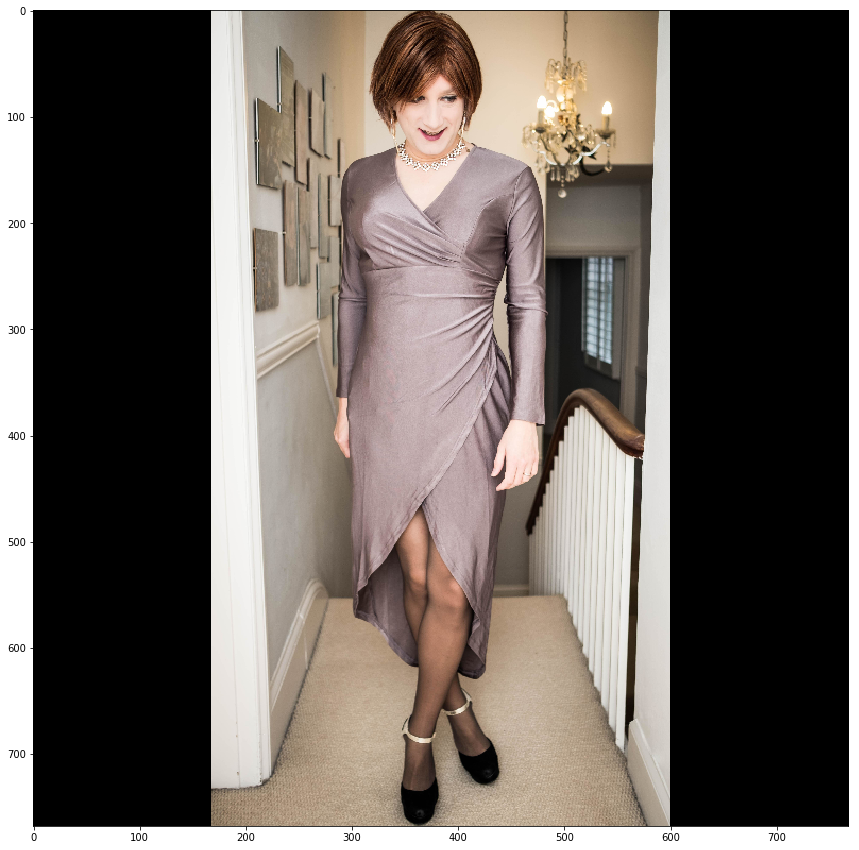

768 432


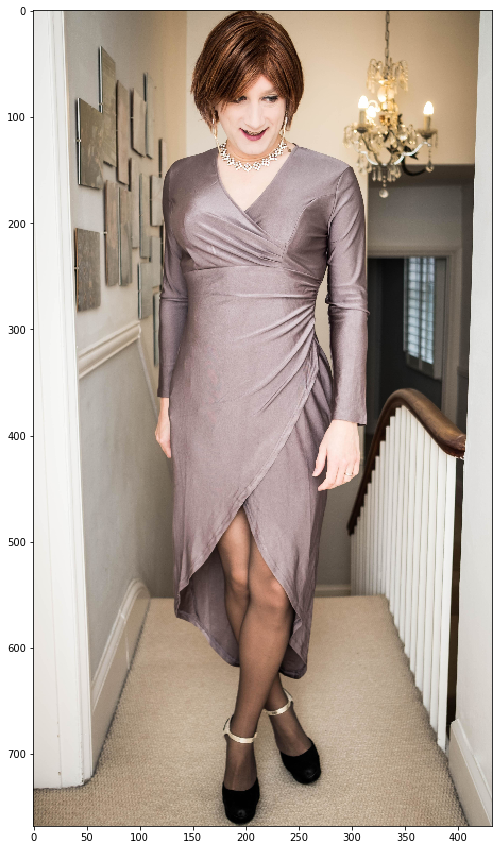

In [13]:
def crop_image(img, paddings):
    original_h, original_w, channels = img.shape
    top_left_y = paddings[0][0]
    top_left_x = paddings[0][1]
    bottom_right_y = original_h - paddings[1][0]
    bottom_right_x = original_w - paddings[1][1]
        
    new_height = bottom_right_y - paddings[0][0] 
    new_width = bottom_right_x - paddings[0][1]
    print(new_height, new_width)
    cropped = np.zeros((new_height, new_width, channels),dtype=np.uint8)
    
    for ch in range(channels):
        cropped[:,:,ch] = img[top_left_y:bottom_right_y,top_left_x:bottom_right_x,ch]
    return cropped
image_id=888
image_path = dataset.image_reference(image_id)[0]
resized_image, paddings = resize_image(image_path)
print(resized_image.dtype, resized_image.shape)
plt.figure(figsize=(15, 15))
plt.imshow(resized_image)
plt.show()
plt.figure(figsize=(15, 15))
cropped_image = crop_image(resized_image, paddings)
plt.imshow(cropped_image)
plt.show()

8888 /home/ubuntu/efs/kaggle/imaterialist/train/31c14a61c5dfc1db60a3926cef22a3a2.jpg
mask size 4128768


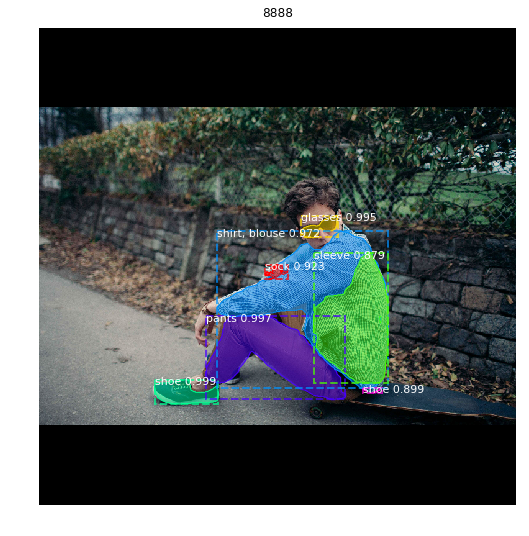

'\nimage, image_meta, gt_class_id, gt_bbox, gt_mask =    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)\ngt_scores = np.ones_like(gt_class_id, dtype=np.float32)\n\nvisualize.display_instances(image, gt_bbox, gt_mask, gt_class_id, \n                            dataset.class_names, gt_scores, #ax=ax,\n                            title="Predictions", figsize=(9, 9))\n\n# Draw precision-recall curve\nAP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,\n                                          r[\'rois\'], r[\'class_ids\'], r[\'scores\'], r[\'masks\'])\nvisualize.plot_precision_recall(AP, precisions, recalls)\n\nvisualize.plot_overlaps(gt_class_id, r[\'class_ids\'], r[\'scores\'],\n                        overlaps, dataset.class_names)\n'

In [17]:
#image_id = random.choice(dataset.image_ids)
image_id = 8888
image_path = dataset.image_reference(image_id)[0]
print(image_id, image_path)

img, paddings = resize_image(image_path)
result = model.detect([img])
r = result[0]
print("mask size", r['masks'].size)

if r['masks'].size > 0:
    masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
    #r['masks'] = crop_image(r['masks'], paddings)
    for m in range(r['masks'].shape[-1]):        
        masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                    (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

    y_scale = img.shape[0]/IMAGE_SIZE
    x_scale = img.shape[1]/IMAGE_SIZE
    rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)

    masks, rois = refine_masks(masks, rois)
else:
    masks, rois = r['masks'], r['rois']

visualize.display_instances(img, rois, masks, r['class_ids'], 
                            ['bg']+label_names, r['scores'],
                            title=image_id, figsize=(9, 9))

image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
gt_scores = np.ones_like(gt_class_id, dtype=np.float32)

visualize.display_instances(image, gt_bbox, gt_mask, gt_class_id, 
                            dataset.class_names, gt_scores, #ax=ax,
                            title="Predictions", figsize=(9, 9))

# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset.class_names)


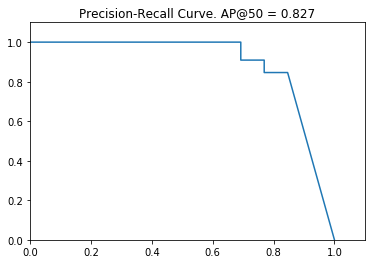

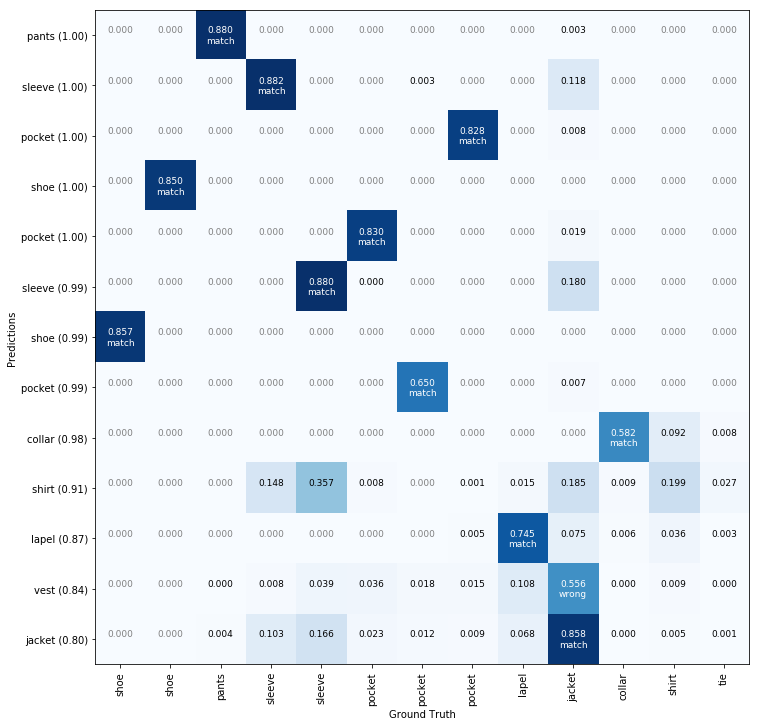

In [49]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset.class_names)

In [156]:
image_id = random.choice(dataset.image_ids)
print(image_id, image_path)

32938 /home/ubuntu/efs/kaggle/imaterialist/train/eff37f3b34491f284dd4bd17e73ed557.jpg


42647 /home/ubuntu/efs/kaggle/imaterialist/train/6d38f9f3971e0080fed4d9ebb93ca0cf.jpg


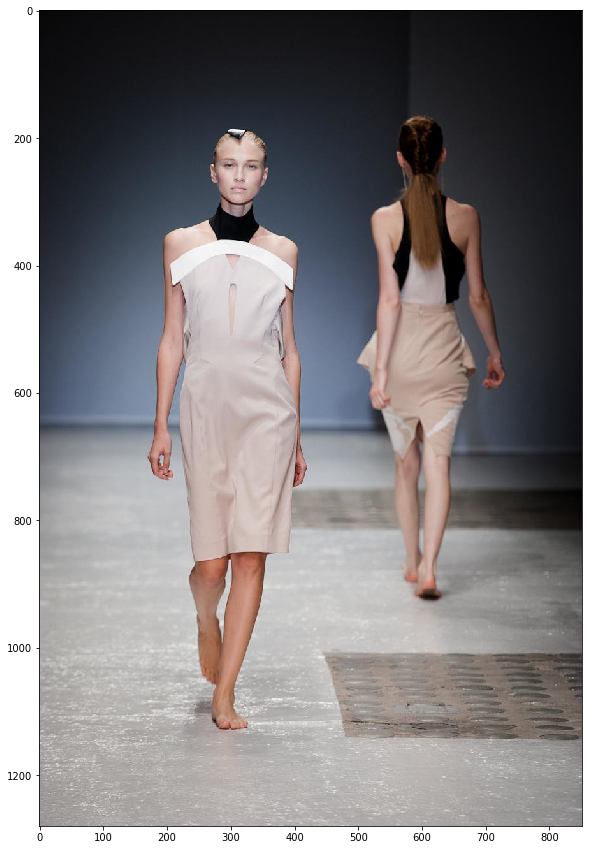

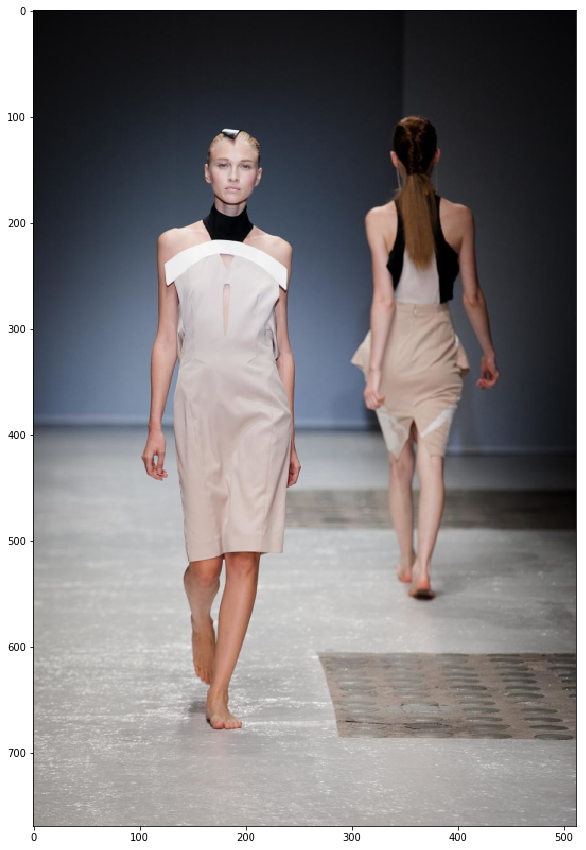

new shape (769, 512, 3)


In [152]:
image_id = random.choice(dataset.image_ids)
print(image_id, image_path)

image_path = dataset.image_reference(image_id)[0]
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


plt.figure(figsize=(15, 15))
plt.imshow(img)
plt.show()
IMAGE_SIZE=512
img_h, img_w, _ = img.shape
if img_h<img_w:
    img = imutils.resize(img, height=IMAGE_SIZE)
else:
    img = imutils.resize(img, width=IMAGE_SIZE)
#img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
plt.figure(figsize=(15, 15))
plt.imshow(img)
plt.show()

print("new shape", img.shape)

In [214]:
label_names

['shirt, blouse',
 'top, t-shirt, sweatshirt',
 'sweater',
 'cardigan',
 'jacket',
 'vest',
 'pants',
 'shorts',
 'skirt',
 'coat',
 'dress',
 'jumpsuit',
 'cape',
 'glasses',
 'hat',
 'headband, head covering, hair accessory',
 'tie',
 'glove',
 'watch',
 'belt',
 'leg warmer',
 'tights, stockings',
 'sock',
 'shoe',
 'bag, wallet',
 'scarf',
 'umbrella',
 'hood',
 'collar',
 'lapel',
 'epaulette',
 'sleeve',
 'pocket',
 'neckline',
 'buckle',
 'zipper',
 'applique',
 'bead',
 'bow',
 'flower',
 'fringe',
 'ribbon',
 'rivet',
 'ruffle',
 'sequin',
 'tassel']

In [215]:
label_descriptions['categories']

[{'id': 0, 'name': 'shirt, blouse', 'supercategory': 'upperbody', 'level': 2},
 {'id': 1,
  'name': 'top, t-shirt, sweatshirt',
  'supercategory': 'upperbody',
  'level': 2},
 {'id': 2, 'name': 'sweater', 'supercategory': 'upperbody', 'level': 2},
 {'id': 3, 'name': 'cardigan', 'supercategory': 'upperbody', 'level': 2},
 {'id': 4, 'name': 'jacket', 'supercategory': 'upperbody', 'level': 2},
 {'id': 5, 'name': 'vest', 'supercategory': 'upperbody', 'level': 2},
 {'id': 6, 'name': 'pants', 'supercategory': 'lowerbody', 'level': 2},
 {'id': 7, 'name': 'shorts', 'supercategory': 'lowerbody', 'level': 2},
 {'id': 8, 'name': 'skirt', 'supercategory': 'lowerbody', 'level': 2},
 {'id': 9, 'name': 'coat', 'supercategory': 'wholebody', 'level': 2},
 {'id': 10, 'name': 'dress', 'supercategory': 'wholebody', 'level': 2},
 {'id': 11, 'name': 'jumpsuit', 'supercategory': 'wholebody', 'level': 2},
 {'id': 12, 'name': 'cape', 'supercategory': 'wholebody', 'level': 2},
 {'id': 13, 'name': 'glasses', 'su

In [216]:
for k, v in label_descriptions.items():
    print(k)

info
categories
attributes


In [232]:
super_cat = set([l['supercategory'] for l in label_descriptions['categories']])
df_catlist = segment_df.groupby('ImageId')['CategoryId'].agg(lambda x: sorted(set(x)))

In [238]:
category_list = []

for supercat in super_cat:
    match_set = set([supercat])
    '''
    match_set = set(['closures',
                     #'garment parts',
                     'decorations', 
                     'others'])
    '''
    for i, row in df_catlist.iteritems():
        temp = sorted(set([label_descriptions['categories'][int(cat)]['supercategory'] for cat in row]))
        label = len(match_set.intersection(temp))>0
        category_list.append(label)
    print("%s %.3f"%(supercat, np.mean(category_list)))

head 0.208
arms and hands 0.149
neck 0.110
decorations 0.127
legs and feet 0.209
wholebody 0.255
others 0.243
lowerbody 0.268
waist 0.254
closures 0.244
garment parts 0.311
upperbody 0.333


In [226]:
len(np.array(category_list))

45625

In [233]:
for x in super_cat:
    print(x)

head
arms and hands
neck
decorations
legs and feet
wholebody
others
lowerbody
waist
closures
garment parts
upperbody



  2%|▏         | 103/5000 [00:48<31:07,  2.62it/s]

KeyboardInterrupt: 

In [32]:
len(dataset.image_ids)*.1

4562.5

In [23]:
for k, v in r.items():
    print(k)

rois
class_ids
scores
masks


In [24]:
len(r['class_ids'])

7

In [25]:
len(r['scores'])

7

In [26]:
r['scores']

array([0.9992236 , 0.9967223 , 0.99496955, 0.9715659 , 0.92257255,
       0.8993932 , 0.87892437], dtype=float32)

In [18]:
np.mean(confidences[1])

0.889151

In [25]:
mean_confidence = [np.mean(confidences[i]) for i in range(46) if math.isnan(confidences[i])!=True]

TypeError: must be real number, not list

In [37]:
mean_confidences

[0.9002696,
 0.9323483,
 0.85859954,
 0.8308185,
 0.9303099,
 0.8022917,
 0.9570897,
 0.94979894,
 0.9146525,
 0.90765744,
 0.9597399,
 0.8889231,
 0.8686,
 0.9634676,
 0.93661094,
 0.8951575,
 0.92672247,
 0.8646411,
 0.9142836,
 0.8914805,
 0.8686,
 0.89742416,
 0.85099304,
 0.96601284,
 0.8866533,
 0.8758745,
 0.8648074,
 0.85875624,
 0.92763615,
 0.931247,
 0.8730725,
 0.95455503,
 0.900282,
 0.94988096,
 0.8818984,
 0.8726082,
 0.8445827,
 0.85617894,
 0.8389577,
 0.8621209,
 0.79586333,
 0.87412286,
 0.8905887,
 0.8512101,
 0.7567036,
 0.8686]

True

In [24]:
np.array(mean_confidence)+0.5*np.array(std_confidence)

array([       nan, 0.93287022, 0.96715143, 0.93586612, 0.87131472,
       0.97108494, 0.82534099, 0.99687734, 0.96611749, 0.96504382,
       0.95135625, 0.99575742, 0.93705461,        nan, 0.99610844,
       0.97485824, 0.94045343, 0.95208897, 0.91861286, 0.9429059 ,
       0.93443139,        nan, 0.94615895, 0.92225322, 0.99764222,
       0.94819691, 0.9016849 , 0.89941962, 0.92137307, 0.97342198,
       0.98121077, 0.91765311, 0.99534594, 0.95100188, 0.98997738,
       0.94558932, 0.91655158, 0.90963924, 0.88533305, 0.79343866,
       0.93239521, 0.80229914, 0.79998231, 0.88046747, 0.93892491,
       0.74479759])

(array([ 9.,  9.,  8.,  8.,  6., 18., 12., 19., 12., 32.]),
 array([0.7086793 , 0.7378109 , 0.7669425 , 0.79607415, 0.82520574,
        0.85433733, 0.8834689 , 0.9126005 , 0.94173217, 0.97086376,
        0.99999535], dtype=float32),
 <a list of 10 Patch objects>)

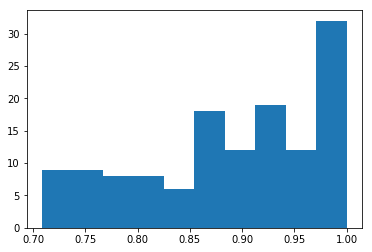

In [26]:
hist, bin_edges = np.histogram(confidences[1],density=True)
plt.hist(confidences[1])

In [29]:
mean_confidence[1]

0.889151